<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 5 -- CNNs, AEs, GANs
https://submitty.cs.rpi.edu/courses/f22/csci4962/course_material/Homeworks/Homework%205.pdf

In [1]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set a fixed randomness
import os
import torch
import random   
import numpy as np
def seed_everything(seed=20):
    """set seed for all"""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [3]:
# import dataset from kaggle
if not os.path.isfile('~/.kaggle/kaggle.json'):
    os.system('mkdir ~/.kaggle')
    os.system('cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json')

!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip vegetable-image-dataset.zip -d .
clear_output()

In [5]:
# Data preprocessing
# import pandas as pd
# images = ['images/images/' + filename for filename in os.listdir('images/images')]
# data_df = pd.read_csv('pokemon.csv')
# data_df['image'] = images
# data_df

In [12]:
img_path = 'Vegetable Images'
# classes = os.listdir(f'{img_path}/train')
# label_map = {v:k for k,v in enumerate(classes)}
# label_map

{'Broccoli': 0,
 'Brinjal': 1,
 'Capsicum': 2,
 'Potato': 3,
 'Cauliflower': 4,
 'Carrot': 5,
 'Bean': 6,
 'Pumpkin': 7,
 'Tomato': 8,
 'Papaya': 9,
 'Cabbage': 10,
 'Bitter_Gourd': 11,
 'Bottle_Gourd': 12,
 'Cucumber': 13,
 'Radish': 14}

In [47]:
import torchvision
transform = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ]),
    'test': torchvision.transforms.Compose([
        torchvision.transforms.Resize([224,224]),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])
}

train_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['train'])
valid_set = torchvision.datasets.ImageFolder(f'{img_path}/train', transform=transform['test'])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [50]:
sample_batch = next(iter(train_loader))
print('Batch image shape:', sample_batch[0].shape)
print('Batch label shape:', sample_batch[1].shape)
print('Label to id:\n\t', '\n\t'.join([f'{k}({v})' for k,v in train_set.class_to_idx.items()]), sep='')
label_map = {v:k for k,v in train_set.class_to_idx.items()}

Batch image shape: torch.Size([32, 3, 224, 224])
Batch label shape: torch.Size([32])
Label to id:
	Bean(0)
	Bitter_Gourd(1)
	Bottle_Gourd(2)
	Brinjal(3)
	Broccoli(4)
	Cabbage(5)
	Capsicum(6)
	Carrot(7)
	Cauliflower(8)
	Cucumber(9)
	Papaya(10)
	Potato(11)
	Pumpkin(12)
	Radish(13)
	Tomato(14)


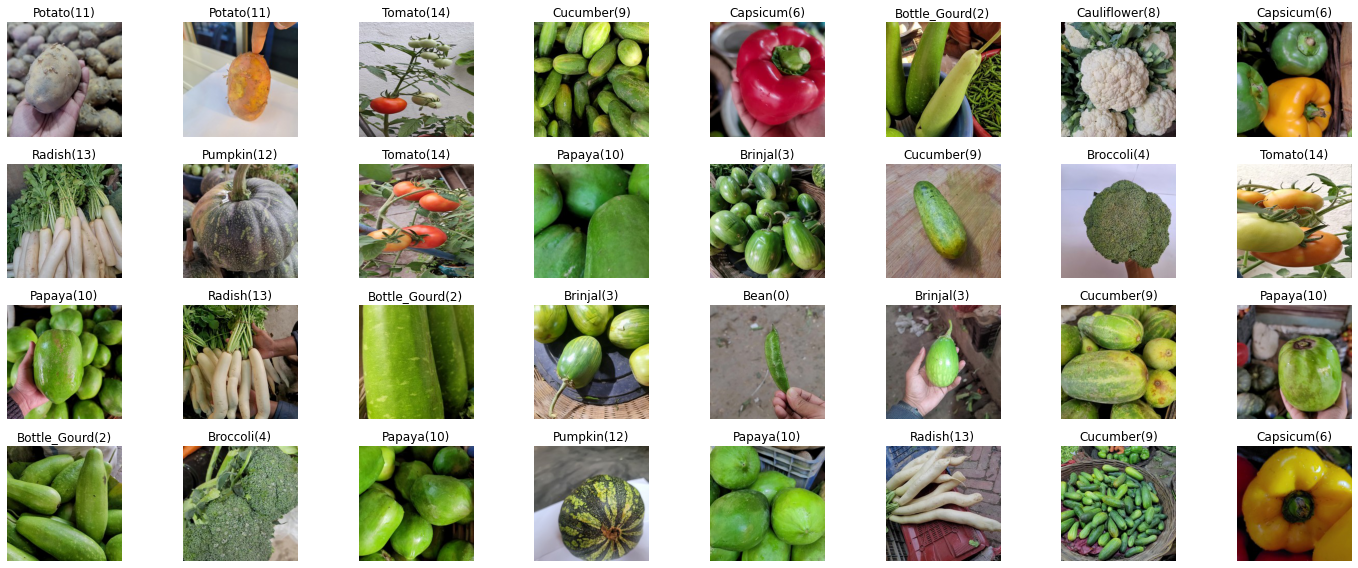

In [51]:
# Random batch visualization
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

# create a sample batch
sample_batch = next(iter(train_loader))
sample_images, sample_labels = sample_batch

sample_count = 32
rows = sample_count // 8
figure, ax = plt.subplots(nrows=rows, ncols=8, figsize=(20, sample_count // rows))

for i, idx in enumerate(range(32)):
    image, label = sample_images[idx], sample_labels[idx]
    image = image / 2 + 0.5
    ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
    title = f'{label_map[sample_labels[idx].item()]}({sample_labels[idx]})'
    ax.ravel()[i].set_title(title)
    ax.ravel()[i].set_axis_off()
    
plt.tight_layout()
plt.show()